In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array
from scipy.stats import mode
from scipy.interpolate import interp1d

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from keras import optimizers
import seaborn as sns

In [2]:
df=pd.read_csv('WISDM.csv', index_col=0)

In [3]:
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [4]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())

In [5]:
df.drop('activity', axis=1, inplace=True)

In [6]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

In [7]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [8]:
df

,user-id,timestamp,X,Y,Z,activityEncode
0,33,49105962326000,-0.694638,12.680544,0.503953,1
1,33,49106062271000,5.012288,11.264028,0.953424,1
2,33,49106112167000,4.903325,10.882658,-0.081722,1
3,33,49106222305000,-0.612916,18.496431,3.023717,1
4,33,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...
1098199,19,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,131623491487000,9.000000,-1.460000,1.730000,2


In [9]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

C:\Users\kkimh\AppData\Local\Temp\ipykernel_3680\2457927958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
C:\Users\kkimh\AppData\Local\Temp\ipykernel_3680\2457927958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
C:\Users\kkimh\AppData\Local\Temp\ipykernel_3680\2457927958.py:3: SettingWithCopyWarning: 
A value i

,user-id,timestamp,X,Y,Z,activityEncode
8489,17,57869902574000,0.510163,0.741908,0.488932,5
8490,17,57870012316000,0.495703,0.751526,0.487895,5
8491,17,57870122301000,0.489850,0.742938,0.484785,5
8492,17,57870222246000,0.499490,0.748778,0.489623,5
8493,17,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...
1098199,19,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,131623491487000,0.723205,0.457755,0.546308,2


In [10]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [11]:
df_train_array = np.array(df_train)
train_set = np.c_[df_train, df_train_array]

df_test_array = np.array(df_test)
test_set = np.c_[df_test, df_test_array]

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

(813398, 25, 11) (813398,)
(284757, 25, 11) (284757,)


In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((813398, 25, 11), (284757, 25, 11), (813398,), (284757,))

In [13]:
## Input and Output Dimensions
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [14]:
print(df['activityEncode'].value_counts())

activityEncode
5    424397
1    342176
4    122869
0    100427
2     59939
3     48395
Name: count, dtype: int64


In [15]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [16]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_test_hot = to_categorical(y_test, num_classes)
print("y_test shape: ", y_train_hot.shape)

y_train shape:  (813398, 6)
y_test shape:  (813398, 6)


In [17]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_hot.shape[1]
print(n_timesteps, n_features, n_outputs)

25 11 6


In [18]:
model = Sequential()
model.add(LSTM(units = 128, input_shape = [n_timesteps, n_features], activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(n_outputs, activation = "softmax"))

In [19]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       


                                                                 
Total params: 88966 (347.52 KB)
Trainable params: 88966 (347.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size=192, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
3813/3813 [==============================] - 114s 30ms/step - loss: nan - accuracy: 0.1191 - val_loss: nan - val_accuracy: 0.0599
Epoch 2/10
3813/3813 [==============================] - 112s 29ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 3/10
3813/3813 [==============================] - 113s 30ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 4/10
3813/3813 [==============================] - 117s 31ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 5/10
3813/3813 [==============================] - 117s 31ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 6/10
3813/3813 [==============================] - 114s 30ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 7/10
3813/3813 [==============================] - 114s 30ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0599
Epoch 8/10
38

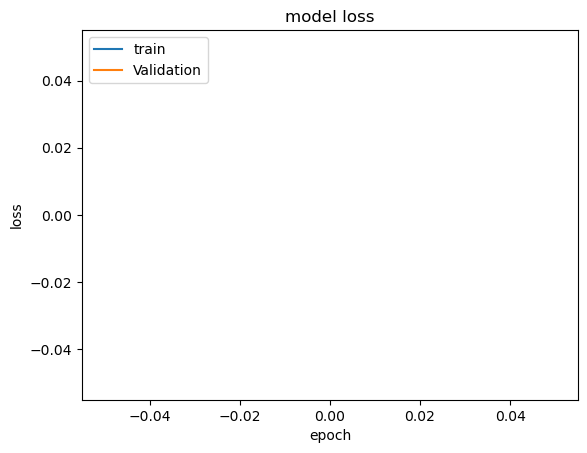

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

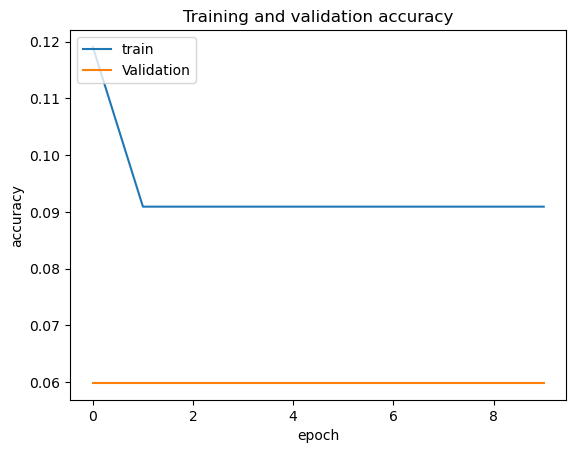

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [23]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

8899/8899 [==============================] - 36s 4ms/step
[[ 28991      0      0      0      0      0]
 [ 79501      0      0      0      0      0]
 [ 18007      0      0      0      0      0]
 [ 16238      0      0      0      0      0]
 [ 31963      0      0      0      0      0]
 [110057      0      0      0      0      0]]
0.10180961310872078


c:\Users\kkimh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kkimh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kkimh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.10      1.00      0.18     28991
           1       0.00      0.00      0.00     79501
           2       0.00      0.00      0.00     18007
           3       0.00      0.00      0.00     16238
           4       0.00      0.00      0.00     31963
           5       0.00      0.00      0.00    110057

    accuracy                           0.10    284757
   macro avg       0.02      0.17      0.03    284757
weighted avg       0.01      0.10      0.02    284757



<Axes: >

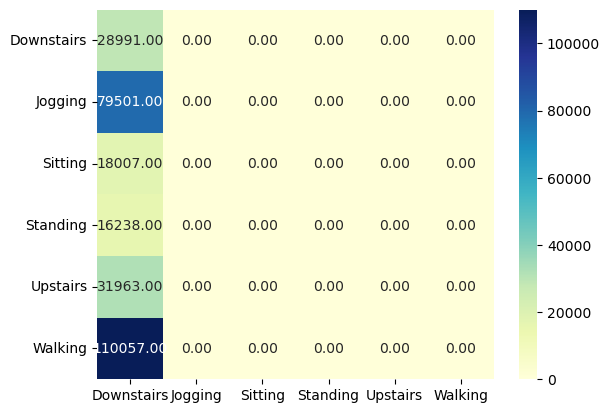

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test2 = np.argmax(y_test_hot, axis=-1)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
cm=confusion_matrix(y_test2,y_pred)

print(cm)
print(accuracy_score(y_test2,y_pred))
print(classification_report(y_test2,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')